In [1]:
from collections import defaultdict
import csv
from sklearn import linear_model
from sklearn.decomposition import PCA
import scipy
import scipy.optimize
import numpy
import random

In [2]:
def readCSV(path):
  f = open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')
    
def calc_model_stats(pred,label):
    
    TP,FP,TN,FN = calc_metrics(pred,label)

    # print("Stats")
    # print(TP,FP,TN,FN)

    # print("Predict N: {} ({}%)".format(TN+FN,(TN+FN)/(TP+TN+FP+FN)))
    # print("Predict P: {} ({}%)".format(TP+FP,(TP+FP)/(TP+TN+FP+FN)))

    accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Accuracy: {}".format(accuracy))
    # print("TPR: {}".format(TPR))
    # print("TNR: {}".format(TNR))
    # print("BER: {}".format(BER))
    
    return
 
def calc_metrics(predictions, labels):
    # Calculate True positives, false positives, etc.

    TP_ = numpy.logical_and(predictions, labels)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(labels))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(labels))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), labels)

    TP=sum(TP_)
    FP=sum(FP_)
    TN=sum(TN_)
    FN=sum(FN_)
    
    return TP,FP,TN,FN

def calc_error_rates(TP, FP, TN, FN):
    # Calculate accuracy, TPR, TNR and BER
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    BER = 1.0 - (TPR+TNR)/2
    
    return accuracy, TPR, TNR, BER


### Generate lists and sets for Similarity Calculations

#### Jaccard Similarity between Books

Jsim(i,j) = Intersection(U_i, U_j)/ Union(U_i, U_j)  

where U_i, U_j are set of readers who have read book i and book j  

#### Pearson Similarity between Books


Psim(i,j) = Sum_Product_crij((R_u_i-AR_u), (R_u_j-AR_u))/ SqRt(Sum_crij(Sq(R_u_i-AR_u)))SqRt(Sum_crij(Sq(R_u_j-AR_u)))  

where 
* crij - the set of readers who have read both book i and j  
* R_u_i = Rating that reader u gives book i  
* AR_u = Average rating given by reader u  





In [6]:
user_Books_full = defaultdict(set)  # Set of (user, books_read)
user_Books_Ratings_full = defaultdict(set)  # Set of (user, set(book_read, rating))
book_Readers_full = defaultdict(set)  # Set of (book, readers)
book_ids=[]

for user,book,rating in X:
  user_Books_full[user].add(book)
  user_Books_Ratings_full[user].add((book,rating))
  book_Readers_full[book].add(user)
  if book not in book_ids:
        book_ids.append(book)

ValueError: not enough values to unpack (expected 3, got 2)

In [20]:
len(user_Books_full),len(user_Books_Ratings_full),len(book_Readers_full), len(book_ids)

(11357, 11357, 7170, 7170)

In [21]:
user_Books_train = defaultdict(set)
user_Books_Ratings_train = defaultdict(set)
book_Readers_train = defaultdict(set)
book_Ratings_train = defaultdict(set)

for user,book,rating in Xtrain:
  user_Books_train[user].add(book)
  user_Books_Ratings_train[user].add((book,rating))
  book_Readers_train[book].add(user)
  book_Ratings_train[book].add(rating)


In [22]:
len(user_Books_train),len(user_Books_Ratings_train),len(book_Readers_train),len(book_Ratings_train)

(11357, 11357, 7170, 7170)

In [8]:
def list_pad(l, n):
    # if len(l) > n, the method truncates the list l to length n 
    # if n > len(l), the method pads list l with zero up to length n 
    return l[:n] + [0]*(n-len(l))

def find_rating(reader,book):
    rating = 0
    for b, rating in user_Books_Ratings_train[reader]:
        if book == b:
            return int(rating)
    return int(rating)

def average_rating(reader):
    ratings = []
    for _, rating in user_Books_Ratings_train[reader]:
        ratings.append(int(rating))
    
    if len(ratings) == 0:
        return 0
    
    return sum(ratings)/len(ratings)

def unread_book(user, read_books):
    # Find a random unread book for a specific user
    
    book = random.choice(book_ids)  # pick a book from full library
    while book in read_books:
        book = random.choice(book_ids)
    return book

"""
Jaccard Similarity
"""

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

"""
When evaluating whether a reader will read a certain book, we can approach it in two ways:
(1) Is the book similar to all the other books the reader has read?
(2) Is the reader similar to all the other readers who have read the same book?
"""

def items_jsim(book1, book2):
    # generate readers set for the 2 books based on train dataset
    s1 = book_Readers_train[book1]
    s2 = book_Readers_train[book2]
    return Jaccard(s1, s2)

def users_jsim(reader1, reader2):
    # generate Books set for the 2 readers based on train dataset
    s1 = user_Books_train[reader1]
    s2 = user_Books_train[reader2]
    return Jaccard(s1, s2)

def jsim_mostSimilar_items(r,b):
    # Find books read by reader r that are most similar to book b
    # and return Jaccard(b, book) in descending order
    jsims = []
    
    # Go through the books read by reader r
    for other_book in user_Books_train[r]:
        if b == other_book: 
           continue   # skip if the book is b
        jsim = items_jsim(b, other_book)
        jsims.append(jsim)
       
    jsims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return jsims  

def jsim_mostSimilar_users(b,r):
    # Find readers who read book b that are most similar to the reader r
    # and return Jaccard(r, reader) in descending order
    jsims = []
    
    # Go through the readers who read book b
    for reader in book_Readers_train[b]:
        if r == reader: 
           continue   # skip if the reader is r
        jsim = users_jsim(r, reader)
        jsims.append(jsim)
       
    jsims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return jsims  


def jaccard_predict(user, book, threshold):
    """
    user_jsims = jsim_mostSimilar_users(book,user)
    if len(user_jsims) is 0:
        max_jsim = 0
    else:
        max_jsim = user_jsims[0]
    """    
    book_jsims = jsim_mostSimilar_items(user,book)
    if len(book_jsims) is 0:
        max_jsim = 0
    else:
        max_jsim = book_jsims[0]
        
    if max_jsim > threshold:
        predict = True
    else:
        predict = False
    return predict, max_jsim

"""
Pearson Similarity

When evaluating whether a reader will read a certain book, we can approach it in two ways:
(1) Is the book similar to all the other books the reader has read?
(2) Is the reader similar to all the other readers who have read the same book?
"""

def users_Pearson(r1,r2):
    
    books_r1 = set([])
    ratings_r1 = []
    
    for book,rating in user_Books_Ratings_train[r1]:
        # print (book,rating)
        books_r1.add(book)
        ratings_r1.append(int(rating))
        
    if len(ratings_r1) == 0:
        avRating_r1 = 0
    else:
        avRating_r1 = sum(ratings_r1)/len(ratings_r1)
        
    # print(books_r1)
    # print(avRating_r1)
    
    books_r2 = set([])
    ratings_r2 = []
    
    for book,rating in user_Books_Ratings_train[r2]:
        # print (book,rating)
        books_r2.add(book)
        ratings_r2.append(int(rating))
        
    if len(ratings_r2) == 0:
        avRating_r2 = 0
    else:
        avRating_r2 = sum(ratings_r2)/len(ratings_r2)  
    
    # print(books_r2)
    # print(avRating_r2)
        
    common = books_r1.intersection(books_r2)
    if len(common) == 0:  # return psim=0 if no common book
        return 0
        
    # print(common)
    
    sumProducts = []
    sumSq_R1 = []
    sumSq_R2 = []
    for book in common:
        pR_r1 = find_rating(r1,book) - avRating_r1
        pR_r2 = find_rating(r2,book) - avRating_r2
        # print(find_rating(r1,book), pR_r1)
        # print(find_rating(r2,book), pR_r2)
        sumProducts.append(pR_r1*pR_r2)
        sumSq_R1.append(pR_r1**2)
        sumSq_R2.append(pR_r2**2)
        
    if sum(sumSq_R1) == 0 or sum(sumSq_R2) == 0:
        return 0
        
    # print(sumProducts)
    # print(sumSq_R1)
    # print(sumSq_R2)
    
    psim = sum(sumProducts)/math.sqrt(sum(sumSq_R1)*sum(sumSq_R2))
    return psim

def items_Pearson(b1,b2):
    
    # Create a set of common readers for book b1 and b2
    readers_b1 = set([])
    for reader in book_Readers_train[b1]:
        readers_b1.add(reader)
        
    readers_b2 = set([])
    for reader in book_Readers_train[b2]:
        readers_b2.add(reader)
        
    common = readers_b1.intersection(readers_b2)
    if len(common) == 0:  # return psim=0 if no common readers
        return 0
        
    # print(common)
    
    sumProducts = []
    sumSq_R1 = []
    sumSq_R2 = []
    for reader in common:
        avRating = average_rating(reader)
        # print(avRating)
        pR_b1 = find_rating(reader,b1) - avRating
        pR_b2 = find_rating(reader,b2) - avRating
        # print(find_rating(reader,b1), pR_b1)
        # print(find_rating(reader,b2), pR_b2)
        sumProducts.append(pR_b1*pR_b2)
        sumSq_R1.append(pR_b1**2)
        sumSq_R2.append(pR_b2**2)
        
    if sum(sumSq_R1) == 0 or sum(sumSq_R2) == 0:
        return 0
        
    # print(sumProducts)
    # print(sumSq_R1)
    # print(sumSq_R2)
    
    psim = sum(sumProducts)/math.sqrt(sum(sumSq_R1)*sum(sumSq_R2))
    return psim

def psim_mostSimilar_users(b,r):
    # Find readers who read book b that are most similar to the reader r
    # and return Pearson(r, reader) in descending order
    psims = []
    
    # Go through the readers who read book b
    for reader in book_Readers_train[b]:
        if r == reader: 
           continue   # skip if the reader is r
        psim = users_Pearson(r, reader)
        # print (reader, psim)
        psims.append(psim)
       
    psims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return psims  

def psim_mostSimilar_items(r,b):
    # Find books read by reader r that are most similar to the book b
    # and return Pearson(b, book) in descending order
    psims = []
    
    # Go through the books read by reader r 
    for book in user_Books_train[r]:
        if book == b: 
           continue   # skip if the book is b
        psim = items_Pearson(b, book)
        # print (book, psim)
        psims.append(psim)
       
    psims.sort(reverse=True)  # sort in descending order of Jaccard Similarity
    return psims  
    

### Split Training Dataset into Train and Validation Datasets

In [9]:
dataset = []

for user,book,rating in readCSV("assignment1/train_Interactions.csv"):
  dataset.append([user,book,rating])

random.shuffle(dataset)

X = [values[0:2] for values in dataset]
y = [int(values[-1]) for values in dataset]

N = len(dataset)
Ntrain = 190001

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:]

print(N, len(ytrain),len(yvalid))

200000 190001 9999


### Adopt code from Workbook 4

In [10]:
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

for user,book,rating in dataset:
    ratingsPerUser[user].append(rating)
    ratingsPerItem[book].append(rating)

N = len(Xtrain)
nUsers = len(ratingsPerUser)
nItems = len(ratingsPerItem)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

print (nUsers, nItems)
print (users[:3])
print (items[:3])

11357 7170
['u98257448', 'u91435928', 'u09361436']
['b50180436', 'b96396550', 'b35131310']


In [11]:
ratingMean = sum([y for y in ytrain])/len(ytrain)

print("Mean of ratings in training set: {}".format(ratingMean))

Mean of ratings in training set: 3.8967426487229013


In [12]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for value in zip(Xtrain,ytrain):
        x,rating = value
        user = x[0]
        book = x[1]
        pred = prediction(user,book)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[user] += 2/N*diff
        dItemBiases[book] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return numpy.array(dtheta)

In [13]:
alwaysPredictMean = [ratingMean for d in Xtrain]

MSE(alwaysPredictMean, ytrain)

1.4731564256297192

In [14]:
numpy.var(ytrain)

1.4731564256256267

## (9) Lambda=1.0, MSE=1.509 for Validation Set

In [15]:
lamb = 1.0
theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),derivative, args = (ytrain, lamb))

MSE = 1.4731564256297192
MSE = 1.455708491441564
MSE = 1.4730066120374512
MSE = 1.4730068696756777
MSE = 1.4730066177516945
MSE = 1.4730066121675425
MSE = 1.4730066120404
MSE = 1.473006612037573
MSE = 1.4730066120374525
MSE = 1.4730066120374512
MSE = 1.4730066120374496
MSE = 1.4730066120374496
MSE = 1.4730066120374508
MSE = 1.4730066120374496
MSE = 1.473006612037451
MSE = 1.4730066120374496
MSE = 1.4730066120374496
MSE = 1.47300661203745
MSE = 1.4730066120374496
MSE = 1.4730066120374508
MSE = 1.4730066120374496


### Extract alpha and betas

In [16]:
unpack(theta)

In [17]:
alpha

3.8967426487228924

In [18]:
predictions = [prediction(user, book) for user,book in Xvalid]
cost = MSE(predictions, yvalid)

print(cost)

1.4982149392405215


## (10) 'u11591742' and 'b57299824' have highest betas

In [19]:
sorted_userBiases  = sorted(userBiases.items(), key=lambda x:x[1])

sorted_userBiases[:10]

[('u11591742', -0.0015229974227424891),
 ('u39338306', -0.0012046010652446205),
 ('u48159222', -0.0008497381739954822),
 ('u00087472', -0.0007321491665724385),
 ('u15620043', -0.0006482229595105764),
 ('u51233768', -0.0006183425164041663),
 ('u76571258', -0.0006093620730744994),
 ('u74183154', -0.0005933062271676205),
 ('u80513837', -0.0005463358657893766),
 ('u00713548', -0.0005189052238680386)]

In [20]:
sorted_itemBiases  = sorted(itemBiases.items(), key=lambda x:x[1])

sorted_itemBiases[:10]

[('b57299824', -0.00027942781558469847),
 ('b47900823', -0.00022407721980972485),
 ('b71442874', -0.00021917761743954465),
 ('b38779837', -0.0002093262057223682),
 ('b81528778', -0.00020731350949277974),
 ('b84203038', -0.00020083507432501843),
 ('b22593148', -0.00019115000810877167),
 ('b47305082', -0.00018581330078309044),
 ('b04083790', -0.0001815139073458508),
 ('b38443676', -0.00018083376718593718)]

In [28]:
lamb_values = [8e-6,1e-5,1.25e-5,1.5e-5,1.6e-5,1.7e-5,1.8e-5,2e-5,5e-5]
MSE_valid =[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems)
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in userBiases:
            cost += lamb*userBiases[u]**2
        for i in itemBiases:
            cost += lamb*itemBiases[i]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        for value in zip(Xtrain,ytrain):
            x,rating = value
            user = x[0]
            book = x[1]
            pred = prediction(user,book)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[user] += 2/N*diff
            dItemBiases[book] += 2/N*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 8e-06
MSE = 1.4805441297166555
MSE = 2.2975032938044913
MSE = 1.4730802389857092
MSE = 1.47283439867937
MSE = 1.47245754248562
MSE = 1.4712028251923286
MSE = 1.468214525005397
MSE = 1.4603205464946034
MSE = 1.4412012310426663
MSE = 1.3985802959211986
MSE = 1.3240231683245256
MSE = 1.2422098107741841
MSE = 1.2013979809025106
MSE = 1.1948764468321484
MSE = 1.1947004618980506
MSE = 1.1943469354789478
MSE = 1.1909235784485865
MSE = 1.1822434666020247
MSE = 1.1608308765149138
MSE = 1.1234835769880327
MSE = 1.0825351175209923
MSE = 1.0616086532523175
MSE = 104.1917756629133
MSE = 1.0574743990729425
MSE = 1.055236289984109
MSE = 1.0540357232641846
MSE = 1.049017357338321
MSE = 1.033377106858927
MSE = 1.011601662942796
MSE = 0.9888519577319868
MSE = 0.9804194113980523
MSE = 0.9785713266891976
MSE = 0.9646743416651443
MSE = 0.9510175622929047
MSE = 0.9518991056066791
MSE = 0.9494408362594754
MSE = 0.9484913864572868
MSE = 0.9366580187161991
MSE = 0.9332381583327394
MSE = 0.932679622052

MSE = 105.76255610054432
MSE = 1.0577691485372116
MSE = 1.0557591618186075
MSE = 1.054564757093724
MSE = 1.0490476600905911
MSE = 1.032607880589378
MSE = 1.0103063798835161
MSE = 0.9967412014877979
MSE = 0.9920438917310186
MSE = 0.9798102890461735
MSE = 0.9780386440306521
MSE = 0.9761513250214595
MSE = 0.9717939651752765
MSE = 0.9660331019888979
MSE = 1.0037419506054432
MSE = 0.964365127012074
MSE = 0.9599806391830504
MSE = 0.9586880240616912
MSE = 0.9584415607629565
MSE = 0.9582416613323613
MSE = 0.9573910784172943
MSE = 0.9554122866155547
MSE = 0.9509967891634968
MSE = 0.9514182772278326
MSE = 0.9491705229540813
MSE = 0.9386603597670584
MSE = 0.9338792292111261
MSE = 0.9302212901929066
MSE = 0.930393711650286
MSE = 0.9301633064231212
MSE = 0.9298022666350748
MSE = 0.9292453034277305
MSE = 0.9284333816589587
MSE = 0.9276407950392705
MSE = 0.9264983334393158
MSE = 0.9300959259844594
MSE = 0.9263887570365507
MSE = 0.9252138432932245
MSE = 0.9246286609528219
MSE = 0.9245158464850157
MSE 

MSE = 0.9722110003889675
MSE = 0.9671457407134592
MSE = 0.9642703689137863
MSE = 0.9610877437639804
MSE = 0.9610958128075426
MSE = 0.960027747528872
MSE = 0.9593527164182097
MSE = 0.9565655094002392
MSE = 0.9537735811777921
MSE = 0.9493619296206965
MSE = 1.2670741596021977
MSE = 0.9477755284013457
MSE = 0.9416206926697637
MSE = 0.9389399216626872
MSE = 0.938794329713487
MSE = 0.939319613546046
MSE = 0.9403628508264337
MSE = 0.9429574735116717
MSE = 0.9395376891873632
MSE = 0.9410157838582244
MSE = 0.9408671864971365
MSE = 0.9392948141157442
MSE = 0.9368337984415894
MSE = 0.9300417127611366
MSE = 1.447120018969379
MSE = 0.9309884307709236
MSE = 0.928438645886971
MSE = 0.9419943268733131
MSE = 0.927690974111649
MSE = 0.9273925992583073
MSE = 0.9254843580967936
MSE = 0.9925825870999461
MSE = 0.9252220470579163
MSE = 0.9228147837862536
MSE = 0.9209517471557699
MSE = 0.9213260979954097
MSE = 0.9216204773431506
MSE = 0.9214485146709392
MSE = 0.9206021537370788
MSE = 0.9205877809178634
MSE = 

MSE = 1.058185690058122
MSE = 1.0564893970431979
MSE = 1.0550816888301067
MSE = 1.0474779574781796
MSE = 1.0283836615326876
MSE = 1.0045501501976897
MSE = 0.9821259962735708
MSE = 0.9829830352545926
MSE = 0.9747100159312461
MSE = 0.9674659639191807
MSE = 0.9533492574694037
MSE = 0.9459666687428229
MSE = 0.9442386297937894
MSE = 0.9448156403040556
MSE = 0.9438206995215884
MSE = 0.942508593401262
MSE = 0.9419405177149218
MSE = 0.9386062703805149
MSE = 0.9382362790943142
MSE = 0.9335537614279774
MSE = 0.9324818823027092
MSE = 0.9320807624004755
MSE = 0.9320823838449707
MSE = 0.9317012903233746
MSE = 0.9314576256290085
MSE = 0.9297290863752482
MSE = 1.5397941261367567
MSE = 0.9296228230996194
MSE = 0.928284077258966
MSE = 0.9271570060255965
MSE = 0.9267759308622486
MSE = 0.9264788073300421
MSE = 0.9254864905233111
MSE = 0.9231348540886759
MSE = 0.9235986313582699
MSE = 0.9227448003310729
MSE = 0.921542685345424
MSE = 0.920624061057265
MSE = 0.9225892240688237
MSE = 0.9212541347340449
MSE =

In [29]:
MSE_valid

[1.1108039952167454,
 1.1090961226343612,
 1.108149717595015,
 1.1080827441140344,
 1.107547823541491,
 1.1070277944583267,
 1.1068034364209327,
 1.1325100917364426,
 1.182853662863315]

## (11) Kaggle Submission - Lambda=1.2e-5,  MSE=1.143, User_Name='Luke Liem'

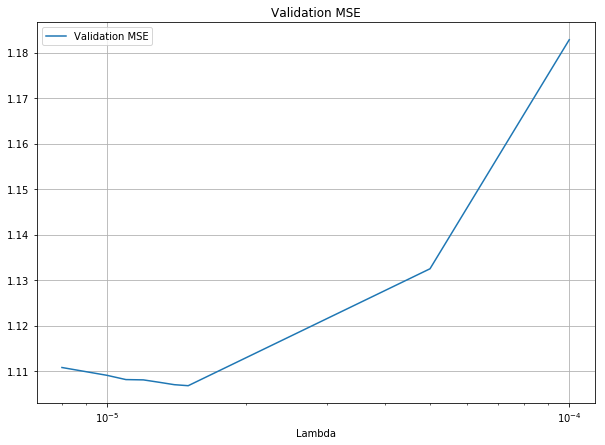

In [30]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.xlabel('Lambda')
plt.title('Validation MSE')
plt.xscale('log')
plt.grid(True)

plt.plot(lamb_values, MSE_valid, label='Validation MSE')

plt.legend()
plt.show()

In [31]:
best_theta

array([ 3.81232674,  0.65968155,  0.19523218, ..., -0.23033841,
        0.0180167 , -0.04204099])

In [32]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()

In [35]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

userGamma = {}
itemGamma = {}

K = 2

# Initialize user and item Gammas
for u in ratingsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in ratingsPerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

In [47]:
def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K
        
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

   
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost


def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in ratingsPerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in ratingsPerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for value in zip(Xtrain,ytrain):
        x,rating = value
        u = x[0]
        i = x[1]
        pred = prediction(u, i)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [48]:
lamb = 0.001
theta_init = [alpha] + [0.0]*(nUsers+nItems) +  \
            [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))]
scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

MSE = 1.4731606725452635
MSE = 1.4585579071198616
MSE = 11.399615272662963
MSE = 1.457355011553468
MSE = 1.362105496200898
MSE = 1.3617641855130933
MSE = 1.3606392194120347
MSE = 1.3607784745127438
MSE = 1.361300203946284
MSE = 1.3608815921069584
MSE = 1.361508747882666
MSE = 1.3609648599608084
MSE = 1.3608945415567408
MSE = 1.3608836532375432
MSE = 1.3608819213762127
MSE = 1.3608816447391514
MSE = 1.360881600520776
MSE = 1.3608815934519811
MSE = 1.3608815923220703
MSE = 1.3608815921413568
MSE = 1.3608815921124637
MSE = 1.3608815921078279
MSE = 1.360881592107075
MSE = 1.3608815921069697
MSE = 1.3608815921070418
MSE = 1.360881592106977
MSE = 1.3608815921069697
MSE = 1.3608815921069755
MSE = 1.3608815921069697
MSE = 1.3608815921069697
MSE = 1.360882984959193
MSE = 1.3608818481480898
MSE = 1.3608816393247558
MSE = 1.3608816008197253
MSE = 1.3608815937150593
MSE = 1.360881592403613
MSE = 1.3608815921616397
MSE = 1.3608815921170523
MSE = 1.360881592108743
MSE = 1.3608815921072497
MSE = 1.36

(array([ 3.87933610e+00,  4.75676895e-02,  1.92375278e-02, ...,
        -8.90784138e-05, -3.42203736e-04, -6.12530994e-04]),
 1.4097564101752147,
 {'funcalls': 44,
  'grad': array([ 1.95098963e-05,  5.05694400e-08,  8.34533129e-07, ...,
         -1.78423220e-07, -6.83913802e-07, -1.22000814e-06]),
  'nit': 7,
  'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

In [49]:
lamb_values = [1e-6,1e-5,1e-4,1e-3,0.01]
MSE_valid =[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems) +  \
            [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))]
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in users:
            cost += lamb*userBiases[u]**2
            for k in range(K):
                cost += lamb*userGamma[u][k]**2
        for i in items:
            cost += lamb*itemBiases[i]**2
            for k in range(K):
                cost += lamb*itemGamma[i][k]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        dUserGamma = {}
        dItemGamma = {}
        for u in ratingsPerUser:
            dUserGamma[u] = [0.0 for k in range(K)]
        for i in ratingsPerItem:
            dItemGamma[i] = [0.0 for k in range(K)]
        for value in zip(Xtrain,ytrain):
            x,rating = value
            u = x[0]
            i = x[1]
            pred = prediction(u, i)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[u] += 2/N*diff
            dItemBiases[i] += 2/N*diff
            for k in range(K):
                dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
                dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
            for k in range(K):
                dUserGamma[u][k] += 2*lamb*userGamma[u][k]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
            for k in range(K):
                dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        for u in users:
            dtheta += dUserGamma[u]
        for i in items:
            dtheta += dItemGamma[i]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 1e-06
MSE = 1.4734631005275007
MSE = 2.2289941967653615
MSE = 1.4729891463264104
MSE = 1.4727831465346721
MSE = 1.4721179345183184
MSE = 1.468897925116665
MSE = 1.4573683245509172
MSE = 1.432848594298881
MSE = 1.3790594454845557
MSE = 1.297683793182218
MSE = 1.2210357433556598
MSE = 1.189803538492067
MSE = 1.1857077773429157
MSE = 1.1848446637231715
MSE = 1.182957043043187
MSE = 1.1770931354657612
MSE = 1.1630902191748085
MSE = 1.1339381809053934
MSE = 1.0939925848696261
MSE = 1.88019161600758
MSE = 1.0918676037333273
MSE = 1.0659253240525661
MSE = 1.0583909826251494
MSE = 1.057281807018967
MSE = 1.0563425915850246
MSE = 1.050347685981483
MSE = 1.0391645448673952
MSE = 1.0184654963128168
MSE = 0.9988208285324273
MSE = 0.9985765279133295
MSE = 0.9938917682054514
MSE = 0.9890699207519269
MSE = 0.9884245407412874
MSE = 0.988021042207404
MSE = 0.9869461681761265
MSE = 0.9835785207975164
MSE = 1.0321413920928233
MSE = 0.9823916923884309
MSE = 0.9759190212249278
MSE = 0.962018252862

MSE = 0.7311010329797539
MSE = 0.5504934637265139
MSE = 0.549839295772244
MSE = 0.54935785150265
MSE = 0.5845717104067994
MSE = 0.5493408842918147
MSE = 0.5492280077424355
MSE = 0.5490482484171575
MSE = 0.5488993171667669
MSE = 0.5483887596699809
MSE = 0.5475141979585454
MSE = 0.5464105453714472
MSE = 0.5461677036630895
MSE = 0.5457550600401011
MSE = 0.5455517690598511
MSE = 0.5453705795414363
MSE = 0.5452593536490007
MSE = 0.5451347704471814
MSE = 0.5453366124325064
MSE = 0.5446735224911158
MSE = 0.5437802501528999
MSE = 0.5420751158591083
MSE = 0.5411057588785745
MSE = 0.5387978154488863
MSE = 0.5383361781870385
MSE = 0.5383374062421769
MSE = 0.5383368625437881
MSE = 0.5384893123942421
MSE = 0.5382968080821143
MSE = 0.5381532165472016
MSE = 0.5373327812222216
MSE = 0.5368708555857774
MSE = 0.5366177636234042
MSE = 0.5366928910506356
MSE = 0.5365564896537538
MSE = 0.5365316043887168
MSE = 0.5361555598228129
MSE = 0.5625988288014345
MSE = 0.5360733579129161
MSE = 0.5356786902287403
MSE

MSE = 0.4935300972634934
MSE = 0.4935209066363572
MSE = 0.4934853200980747
MSE = 0.4934378316089915
MSE = 0.4953387413607877
MSE = 0.4934399092120351
MSE = 0.4933988595688332
MSE = 0.4933590545961987
MSE = 0.4933315575538054
MSE = 0.49329188444275257
MSE = 0.49332245708489336
MSE = 0.49327955649781385
MSE = 0.4932368227489376
MSE = 0.5078418018759662
MSE = 0.4932402343223328
MSE = 0.49321015270066
MSE = 0.49319311115587705
MSE = 0.49311119551679505
MSE = 0.4936403122362767
MSE = 0.4931072005477547
MSE = 0.4929852536550268
MSE = 0.4927679223370117
MSE = 0.49282299426038473
MSE = 0.4926376395482543
MSE = 0.49240992179733345
MSE = 0.49242797500384555
MSE = 0.49238235820900833
MSE = 0.4923051823783196
MSE = 0.49225462974718537
MSE = 0.4922749729864694
MSE = 0.4922455118587826
MSE = 0.4921877560558174
MSE = 0.4921607763911802
MSE = 0.4921375845654485
MSE = 0.49215343997939953
MSE = 0.49205352260839297
MSE = 0.49204335816846595
MSE = 0.49199978479138884
MSE = 0.49196132420721017
MSE = 0.4919

MSE = 0.4861635125738204
MSE = 0.48616104487027434
MSE = 0.4861306773880942
MSE = 0.4860482545078755
MSE = 0.48605868276970937
MSE = 0.48603988844919266
MSE = 0.48601774731602626
MSE = 0.48597950551428876
MSE = 0.48599066385574613
MSE = 0.48595574105758527
MSE = 0.485923036312163
MSE = 0.48586620221188553
MSE = 0.4858610002169216
MSE = 0.4858670151844048
MSE = 0.4858647824709476
MSE = 0.48585101033423955
MSE = 0.4858225854315414
MSE = 0.48578469585362805
MSE = 0.4857804810710911
MSE = 0.48576698853806805
MSE = 0.48575046948615425
MSE = 0.4857309193122138
MSE = 0.48571945099215713
MSE = 0.48571903619922535
MSE = 0.4857135532605047
MSE = 0.485702862709649
MSE = 0.48568246685156174
MSE = 0.4856409819280203
MSE = 0.48582233473115904
MSE = 0.4856522076332845
MSE = 0.48700371198544323
MSE = 0.4856538899431441
MSE = 0.4856459997585467
MSE = 0.4856377981714964
MSE = 0.48563315473221125
MSE = 0.4856225006756062
MSE = 0.4855400525723803
MSE = 0.48550089796656265
MSE = 0.48549090069398043
MSE = 0

KeyboardInterrupt: 